In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from utils import *

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
target = 'category'
fake_data_name = 'restyle'
retrain = False

### 1. Prepare Data

In [4]:
train_real, test_real = prepare_data(target, 'real_images_embeddings')
train_fake, test_fake = prepare_data(target, fake_data_name)

# Combine real and fake data
train = ConcatDataset([train_real, train_fake])
test = ConcatDataset([test_real, test_fake])

print(f"Target: {train_real.target}")
print(f"\tNumber of classes: {len(train_real.id2label)}")

print(f"\tNumber of training samples: {len(train)}")
print(f"\tNumber of testing samples: {len(test)}")

Target: category
	Number of classes: 8
	Number of training samples: 22496
	Number of testing samples: 5624


### 2. Training

In [5]:
## Model Parameters
embeddings_shape = train_real[0][0].shape[0]
num_classes = len(train_real.id2label)

## Training Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
LR = 5e-4
loss_fn = nn.CrossEntropyLoss()

## Initialize Model and Optimizer
device = set_device()
model = ClassifierModel(embeddings_shape, num_classes)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

model_save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{target}_{fake_data_name}.pt"

Using cpu as device


In [6]:
# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
if retrain or not os.path.exists(model_save_path):
    train_model(model, NUM_EPOCHS, optimizer, loss_fn, train_loader, test_loader, model_save_path, device, log_every=10)
else:
    model = torch.load(model_save_path, map_location = 'cpu')

### 3. Evaluation

In [7]:
print("Overall Accuracy:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test), device)}")

print("Accuracy on real data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_real), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_real), device)}")

print("Accuracy on fake data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_fake), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_fake), device)}")

Overall Accuracy:
	Training Set: 0.9197635135135135
	Testing Set: 0.6575391180654339
Accuracy on real data:
	Training Set: 0.9369665718349929
	Testing Set: 0.7037695590327169
Accuracy on fake data:
	Training Set: 0.9025604551920341
	Testing Set: 0.6113086770981507


#### Top N Accuracy

In [8]:
real_loader = DataLoader(ConcatDataset([train_real, test_real]), batch_size=BATCH_SIZE, shuffle=False)
fake_loader = DataLoader(ConcatDataset([train_fake, test_fake]), batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def get_top_n_predictions(loader, n):
    predictions = {}

    for embeddings, labels, sku in loader:
        output = model(embeddings.to(device))
        prob, predicted = torch.topk(torch.softmax(output, 1), n)

        for i in range(len(predicted)):
            predictions[sku[i]] = [train_real.id2label[labels[i].item()]] + [train_real.id2label[predicted[i][j].item()] for j in range(n)] + [prob[i][j].item() for j in range(n)]

    df = pd.DataFrame(predictions).T.reset_index()
    df.columns = ['sku'] + ['target'] + [f'pred_{i}' for i in range(n)] + [f'prob_{i}' for i in range(n)]

    df['top1_correct'] = df['target'] == df['pred_0']
    for i in range(1, n):
        df[f'top{i+1}_correct'] = df[f'top{i}_correct'] | (df['target'] == df[f'pred_{i}'])
    return df


In [10]:
real_predictions = get_top_n_predictions(real_loader, 3)
fake_predictions = get_top_n_predictions(fake_loader, 3)

real_predictions['dataset'] = real_predictions.sku.apply(lambda x: 'train' if x in train_real.df.sku.to_list() else 'test')
fake_predictions['dataset'] = fake_predictions.sku.apply(lambda x: 'train' if x in train_fake.df.sku.to_list() else 'test')

In [11]:
print("Real Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {real_predictions[real_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

print("Reconstructed Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {fake_predictions[fake_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

Real Images:
	Train Set:
		Top 1: 0.9369665718349929
		Top 2: 0.9903093883357041
		Top 3: 0.9978662873399715
	Test Set:
		Top 1: 0.7037695590327169
		Top 2: 0.8730440967283073
		Top 3: 0.9473684210526315
Reconstructed Images:
	Train Set:
		Top 1: 0.9025604551920341
		Top 2: 0.9797297297297297
		Top 3: 0.9957325746799431
	Test Set:
		Top 1: 0.6113086770981507
		Top 2: 0.8093883357041252
		Top 3: 0.9068278805120911


In [12]:
print('Real Images:')
display(real_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False))

print('Reconstructed Images:')
fake_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False)

Real Images:


target
Denim dress                     0.964744
Jumper dress                    0.942685
Cocktail dress / Party dress    0.934881
Day dress                       0.897348
Occasion wear                   0.882497
Maxi dress                      0.875085
Jersey dress                    0.809497
Shift dress                     0.787202
Name: top1_correct, dtype: float64

Reconstructed Images:


target
Denim dress                     0.910256
Cocktail dress / Party dress    0.907701
Occasion wear                   0.887393
Jumper dress                    0.881850
Day dress                       0.852318
Maxi dress                      0.798371
Jersey dress                    0.786034
Shift dress                     0.677083
Name: top1_correct, dtype: float64

In [13]:
pd.crosstab(real_predictions.target, real_predictions.pred_0)

pred_0,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
target,,,,,,,,
Cocktail dress / Party dress,1651,59,1,8,3,13,21,10
Day dress,183,4703,3,162,52,116,6,16
Denim dress,0,10,301,0,1,0,0,0
Jersey dress,67,140,0,1449,65,39,5,25
Jumper dress,23,34,0,41,1875,7,1,8
Maxi dress,41,86,0,19,19,1289,17,2
Occasion wear,44,9,0,6,4,33,721,0
Shift dress,62,15,0,36,28,1,1,529


### Check some misclassified examples

In [14]:
def display_missclassified_samples(miss, num_samples=5):
    sample = miss.sample(num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(5 * num_samples, 10))

    for i in range(num_samples):
        sku = sample.iloc[i].sku
        img_path = f"{DATA_PATH}/Generated_Images/restyle/inference_results/4/{sku}.jpg"
        img = Image.open(img_path)
        ax[i].imshow(img)

        # Construct title string with predictions and their probabilities
        title_text = f"SKU: {sku}\nTarget: {sample.iloc[i].target}"
        for j in range(3):  # Assuming there are always three predictions to display
            pred_col = f'pred_{j}'
            prob_col = f'prob_{j}'
            title_text += f"\nPrediction {j + 1}: {sample.iloc[i][pred_col]} ({np.round(sample.iloc[i][prob_col], 2)})"

        ax[i].set_title(title_text)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


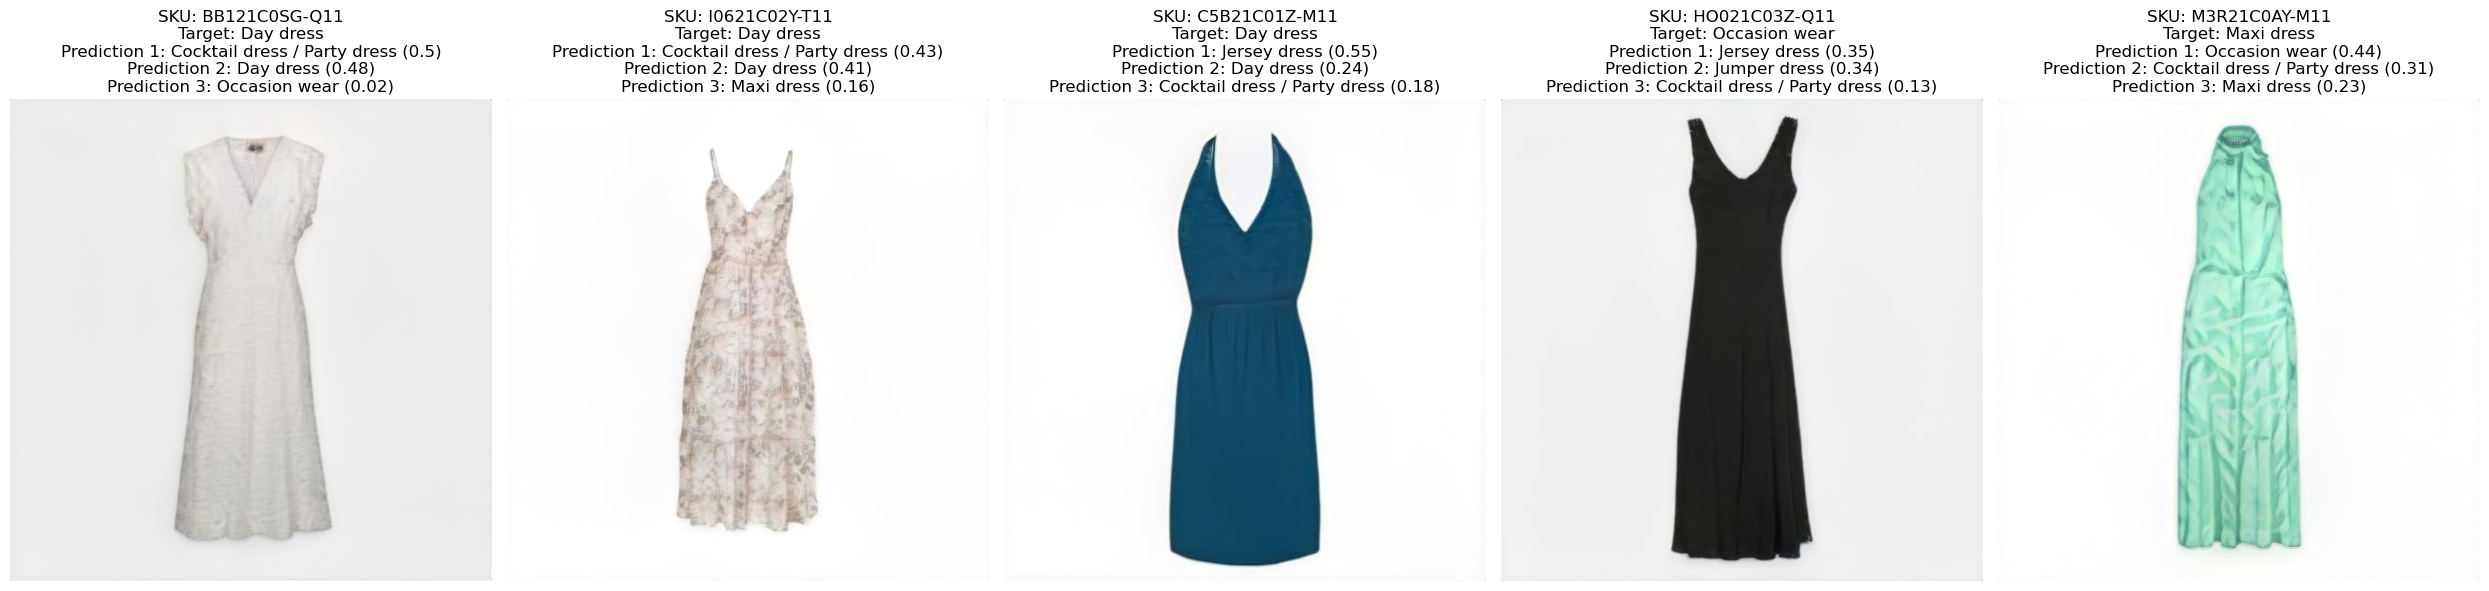

In [15]:
miss = fake_predictions[fake_predictions.target != fake_predictions.pred_0]
display_missclassified_samples(miss, 5)